## 제주도의 지역적 특성에 따른 재난지원금 소비 동향

1. 제주도의 시, 지역 별 특성에 따른 재난지원금 소비 패턴
2. 타지역(육지)와의 재난지원금 소비 패턴 비교를 통한 제주도의 도메인적 특성

사용한 데이터:
- 메인 데이터: https://dacon.io/competitions/official/235682/data/
- 국내 재난지원금 신청,지급 가구수 데이터: https://www.mois.go.kr/frt/bbs/type010/commonSelectBoardArticle.do?bbsId=BBSMSTR_000000000008&nttId=77379
- 카카오톡 지도 오픈 API: https://developers.kakao.com/docs/latest/ko/local/dev-guide

In [117]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [118]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.rc('font', family='NanumBarunGothic') #한글 폰트 지정
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/Library/Fonts/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

In [119]:
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [120]:
data5 = pd.read_csv('data/KRI-DAC_Jeju_data5.txt')
data6 = pd.read_csv('data/KRI-DAC_Jeju_data6.txt')
data7 = pd.read_csv('data/KRI-DAC_Jeju_data7.txt')
data8 = pd.read_csv('data/KRI-DAC_Jeju_data8.txt')

data = pd.concat([data5, data6, data7, data8])
data = data.reset_index(drop=True)
data.head(3)

,OBJECTID,Field1,YM,SIDO,SIGUNGU,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y,X,Y
0,1,1,202005,제주특별자치도,제주시,영세,일반한식,00시,363000,66500,10,2,877005.9834,1.479766e+06,NaN,NaN
1,2,2,202005,제주특별자치도,제주시,영세,단란주점,00시,1180000,0,3,0,877005.7447,1.479816e+06,NaN,NaN
2,3,3,202005,제주특별자치도,제주시,중소1,편의점,00시,157670,6850,20,2,877056.6756,1.479616e+06,NaN,NaN


**데이터 columns 정의**

- YM : 기준년월
- SIDO : 지역대분류명
- SIGUNGU : 지역중분류명
- FranClass : 소상공인구분
- Type : 업종명
- Time : 시간대
- TotalSpent : 총사용금액
- DisSpent : 재난지원금 사용금액
- NumOfSpent : 총 이용건수
- NumOfDisSpent : 총 재난지원금 이용건수
- POINT_X, POINT_Y : X,Y 좌표

In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119429 entries, 0 to 1119428
Data columns (total 16 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   OBJECTID       1119429 non-null  int64  
 1   Field1         1119429 non-null  int64  
 2   YM             1119429 non-null  int64  
 3   SIDO           1119429 non-null  object 
 4   SIGUNGU        1119429 non-null  object 
 5   FranClass      1119429 non-null  object 
 6   Type           1119429 non-null  object 
 7   Time           1119429 non-null  object 
 8   TotalSpent     1119429 non-null  int64  
 9   DisSpent       1119429 non-null  int64  
 10  NumofSpent     1119429 non-null  int64  
 11  NumofDisSpent  1119429 non-null  int64  
 12  POINT_X        1119429 non-null  float64
 13  POINT_Y        1119429 non-null  float64
 14  X              284265 non-null   float64
 15  Y              284265 non-null   float64
dtypes: float64(4), int64(7), object(5)
memory usage: 136.6

## 1. 데이터 전처리

In [122]:
# 중복되는 column OBJECTID, Field1 drop
data = data.drop(["OBJECTID","Field1"], axis = 1)

# 불필요한 X, Y column drop
data = data.drop(["X","Y"], axis = 1)

# id를 index로 설정
data.reset_index(drop="index", inplace=False)
data.head()

,YM,SIDO,SIGUNGU,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y
0,202005,제주특별자치도,제주시,영세,일반한식,00시,363000,66500,10,2,877005.9834,1.479766e+06
1,202005,제주특별자치도,제주시,영세,단란주점,00시,1180000,0,3,0,877005.7447,1.479816e+06
2,202005,제주특별자치도,제주시,중소1,편의점,00시,157670,6850,20,2,877056.6756,1.479616e+06
3,202005,제주특별자치도,제주시,영세,편의점,00시,46600,0,2,0,877055.9593,1.479766e+06
4,202005,제주특별자치도,제주시,영세,주점,00시,66000,0,2,0,877055.4817,1.479866e+06


### 1-1 좌표계 변환

참고: https://github.com/domug/DSL/blob/master/EDA%20%EC%84%B8%EC%85%98/%EC%A2%8C%ED%91%9C%EA%B3%84%20%EB%B3%80%ED%99%98%20%ED%8A%9C%ED%86%A0%EB%A6%AC%EC%96%BC.ipynb

In [123]:
## 좌표계 변환 
from pyproj import Proj, transform
import geopandas as gpd

def get_WGS84(coordinates):
    """
    UTM-K 좌표계를 WGS로 변환해주는 함수.
    coordinates: UTM-K 좌표 리스트
    """
    proj_WGS84 = Proj(init="epsg:4326") # WGS1984
    proj_UTMK = Proj('+proj=tmerc +lat_0=38 +lon_0=127.5 +k=0.9996 +x_0=1000000 +y_0=2000000 +ellps=GRS80 + units=m +no_defs')  # UTM-K 좌표계 변환 공식
    
    long = [x[0] for x in coordinates]  # UTM-K 경도
    lat = [x[1] for x in coordinates]   # UTM-K 위도
    
    coordinates_w84 = transform(proj_UTMK, proj_WGS84, long, lat)
    
    return coordinates_w84

In [124]:
coords_utmk = list(zip(list(data.POINT_X), list(data.POINT_Y)))

# 좌표 변환
coords_wgs84 = get_WGS84(coords_utmk)

# 데이터 프레임 좌표값 수정
data["POINT_X"] = coords_wgs84[0]
data["POINT_Y"] = coords_wgs84[1]

In [125]:
data.head(3)

,YM,SIDO,SIGUNGU,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y
0,202005,제주특별자치도,제주시,영세,일반한식,00시,363000,66500,10,2,126.178894,33.302315
1,202005,제주특별자치도,제주시,영세,단란주점,00시,1180000,0,3,0,126.178884,33.302766
2,202005,제주특별자치도,제주시,중소1,편의점,00시,157670,6850,20,2,126.179458,33.300971


### 1-2 Kakao API를 사용해서 제주도 읍면동 column 추가해주기

In [51]:
# API 참고: https://developers.kakao.com/docs/latest/ko/local/dev-guide

In [128]:
import requests
import json
url = "https://dapi.kakao.com/v2/local/geo/coord2regioncode.json?x=126.178894&y=33.302315"

# kakao accesskey: https://developers.kakao.com/console/app/534978/config/appKey
headers = {"Authorization": "KakaoAK d4f37e7d53bab4b922a0c15bd854a71b"}
api_test = requests.get(url,headers=headers)
url_text = json.loads(api_test.text)
url_text

{'errorType': 'RequestThrottled', 'message': 'API limit has been exceeded.'}

In [115]:
url = ('https://dapi.kakao.com/v2/local/geo/coord2regioncode.json?x={}&y={}'.format(POINT_X, POINT_Y))
headers = {"Authorization": "KakaoAK d4f37e7d53bab4b922a0c15bd854a71b"}

api_test = requests.get(url,headers=headers)
url_text = json.loads(api_test.text)
url_text["documents"][0]

KeyError: 'documents'

In [109]:
count = 0
for i, j in data.iterrows():
    POINT_X = j.POINT_X
    POINT_Y = j.POINT_Y
    url = ('https://dapi.kakao.com/v2/local/geo/coord2regioncode.json?x={}&y={}'.format(POINT_X, POINT_Y))
    api_test = requests.get(url,headers=headers)
    url_text = json.loads(api_test.text)
    data["DONG"] = url_text["documents"][0]["region_3depth_name"]
    count += 1
    if (count % 1000 == 0):
        print("progress {}/10000".format(count))
    if i == 10000:
        break
    

progress 1000/10000
progress 2000/10000
progress 3000/10000
progress 4000/10000
progress 5000/10000


KeyError: 'documents'

In [110]:
data

,YM,SIDO,SIGUNGU,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y,DONG
0,202005,제주특별자치도,제주시,영세,일반한식,00시,363000,66500,10,2,126.178894,33.302315,노형동
1,202005,제주특별자치도,제주시,영세,단란주점,00시,1180000,0,3,0,126.178884,33.302766,노형동
2,202005,제주특별자치도,제주시,중소1,편의점,00시,157670,6850,20,2,126.179458,33.300971,노형동
3,202005,제주특별자치도,제주시,영세,편의점,00시,46600,0,2,0,126.179430,33.302323,노형동
4,202005,제주특별자치도,제주시,영세,주점,00시,66000,0,2,0,126.179412,33.303224,노형동
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119424,202008,제주특별자치도,제주시,영세,편의점,x시,13700,0,2,0,126.964496,33.512854,노형동
1119425,202008,제주특별자치도,제주시,영세,일반한식,x시,56000,0,1,0,126.965056,33.511056,노형동
1119426,202008,제주특별자치도,제주시,영세,일반한식,x시,28000,0,1,0,126.966708,33.507914,노형동
1119427,202008,제주특별자치도,제주시,중소1,중국음식,x시,46000,0,3,0,126.967907,33.497555,노형동


In [111]:
data.to_csv('jeju_dong.csv', index=False)

In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119429 entries, 0 to 1119428
Data columns (total 13 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   YM             1119429 non-null  int64  
 1   SIDO           1119429 non-null  object 
 2   SIGUNGU        1119429 non-null  object 
 3   FranClass      1119429 non-null  object 
 4   Type           1119429 non-null  object 
 5   Time           1119429 non-null  object 
 6   TotalSpent     1119429 non-null  int64  
 7   DisSpent       1119429 non-null  int64  
 8   NumofSpent     1119429 non-null  int64  
 9   NumofDisSpent  1119429 non-null  int64  
 10  POINT_X        1119429 non-null  float64
 11  POINT_Y        1119429 non-null  float64
 12  DONG           1119429 non-null  object 
dtypes: float64(2), int64(5), object(6)
memory usage: 111.0+ MB


In [114]:
print(data.DONG.unique())

['노형동']


### 1-3 범주형 변수 탐색

In [19]:
# 범주형 변수에 대한 데이터 값들 탐색
print(data.SIDO.unique())
print(data.SIGUNGU.unique())
print(data.FranClass.unique())
print(data.Type.unique())
print(data.Time.unique())
print(data.DONG.unique())

['제주특별자치도']
['제주시' '서귀포시']
['영세' '중소1' '중소' '중소2' '일반']
['일반한식' '단란주점' '편의점' '주점' '스넥' '서양음식' '일식회집' '기타음료식품' '노래방' '중국음식' '슈퍼마켓'
 '유흥주점' '기타숙박업' '기타레져업' '당구장' '농축수산품' '유아원' '골프경기장' '세탁소' '가방' '콘도' '주차장'
 '문화취미기타' '주유소' '사무서비스' '자동차정비' '특급호텔' '볼링장' '화장품' '기타회원제형태업소' '주류판매점'
 '제과점' '피부미용실' '약국' '칵테일바' '정육점' '독서실' '스포츠레져용품' '골프용품' 'LPG' '종합병원' '사우나'
 '화원' '의원' '안마스포츠마사지' '골프연습장' '2급호텔' '기타대인서비스' '보습학원' '부동산분양' '화물운송'
 '애완동물' '동물병원' '대형할인점' '인터넷Mall' '항공사' '헬스크럽' '기타유통업' '레져용품수리' '정장'
 '레져업소(회원제형태)' '관광여행' '1급호텔' '침구수예점' '사진관' '악세사리' '보관창고업' '기념품점' '미용원'
 '영화관' '의료용품' '세차장' '인터넷종합Mall' '기타잡화' '성인용품점' '상품권' '종합용역' '기계공구' '조세서비스'
 '택시' '기타의료기관및기기' '가례서비스' '구내매점' '수영장' '목재석재철물' '건축요업품' '기타업종' '렌트카'
 '종합레져타운' '유류판매' '농축협직영매장' '기타건축자재' '비료농약사료종자' '농기계' '보일러펌프' '가전제품'
 '스포츠의류' '페인트' '미곡상' '기타농업관련' '기타가구' '공공요금' '기능학원' '면세점' '기타교육' '위탁급식업'
 '이용원' '조명기구' '문구용품' '인테리어' '민예공예품' '기타연료' '자동차부품' '기타용역서비스' '기타운송' '연쇄점'
 '옷감직물' '한의원' '주방용식기' '카인테리어' '기타수리서비스' '농협하나로클럽' '기타건강식' '티켓' '기타전기제품'
 '일반서적' '외국어

## 2. 제주도 내 지역별 재난지원금 소비 동향

**제주도 도메인적 특성**
> 제주시
- 제주시 북쪽에 제주국제공항 위치
- 신제주(제주공항을 중심으로 서쪽), 구제주(제주공항을 중심으로 동쪽)
- 북동쪽은 그렇게 발달되지 않은 지역

> 서귀포시
- 중문을 기점으로 관광단지 발달
- 애월읍, 한림읍: 관광명소
- 성산읍: 성산일출봉, 우도 등 관광명소


In [132]:
jeju_data = data

In [134]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119429 entries, 0 to 1119428
Data columns (total 12 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   YM             1119429 non-null  int64  
 1   SIDO           1119429 non-null  object 
 2   SIGUNGU        1119429 non-null  object 
 3   FranClass      1119429 non-null  object 
 4   Type           1119429 non-null  object 
 5   Time           1119429 non-null  object 
 6   TotalSpent     1119429 non-null  int64  
 7   DisSpent       1119429 non-null  int64  
 8   NumofSpent     1119429 non-null  int64  
 9   NumofDisSpent  1119429 non-null  int64  
 10  POINT_X        1119429 non-null  float64
 11  POINT_Y        1119429 non-null  float64
dtypes: float64(2), int64(5), object(5)
memory usage: 102.5+ MB


### 2-1 시별 총사용금액 vs 재난지원금사용금액

In [144]:
# 업종별 재난지원금 사용

plt.figure(figsize=(20,10))
ax = sns.barplot(x="DisSpent", y="Total_Spent", data=tips)

NameError: name 'tips' is not defined

<Figure size 1440x720 with 0 Axes>

### 2-2 시별 업종별 재난지원금 사용

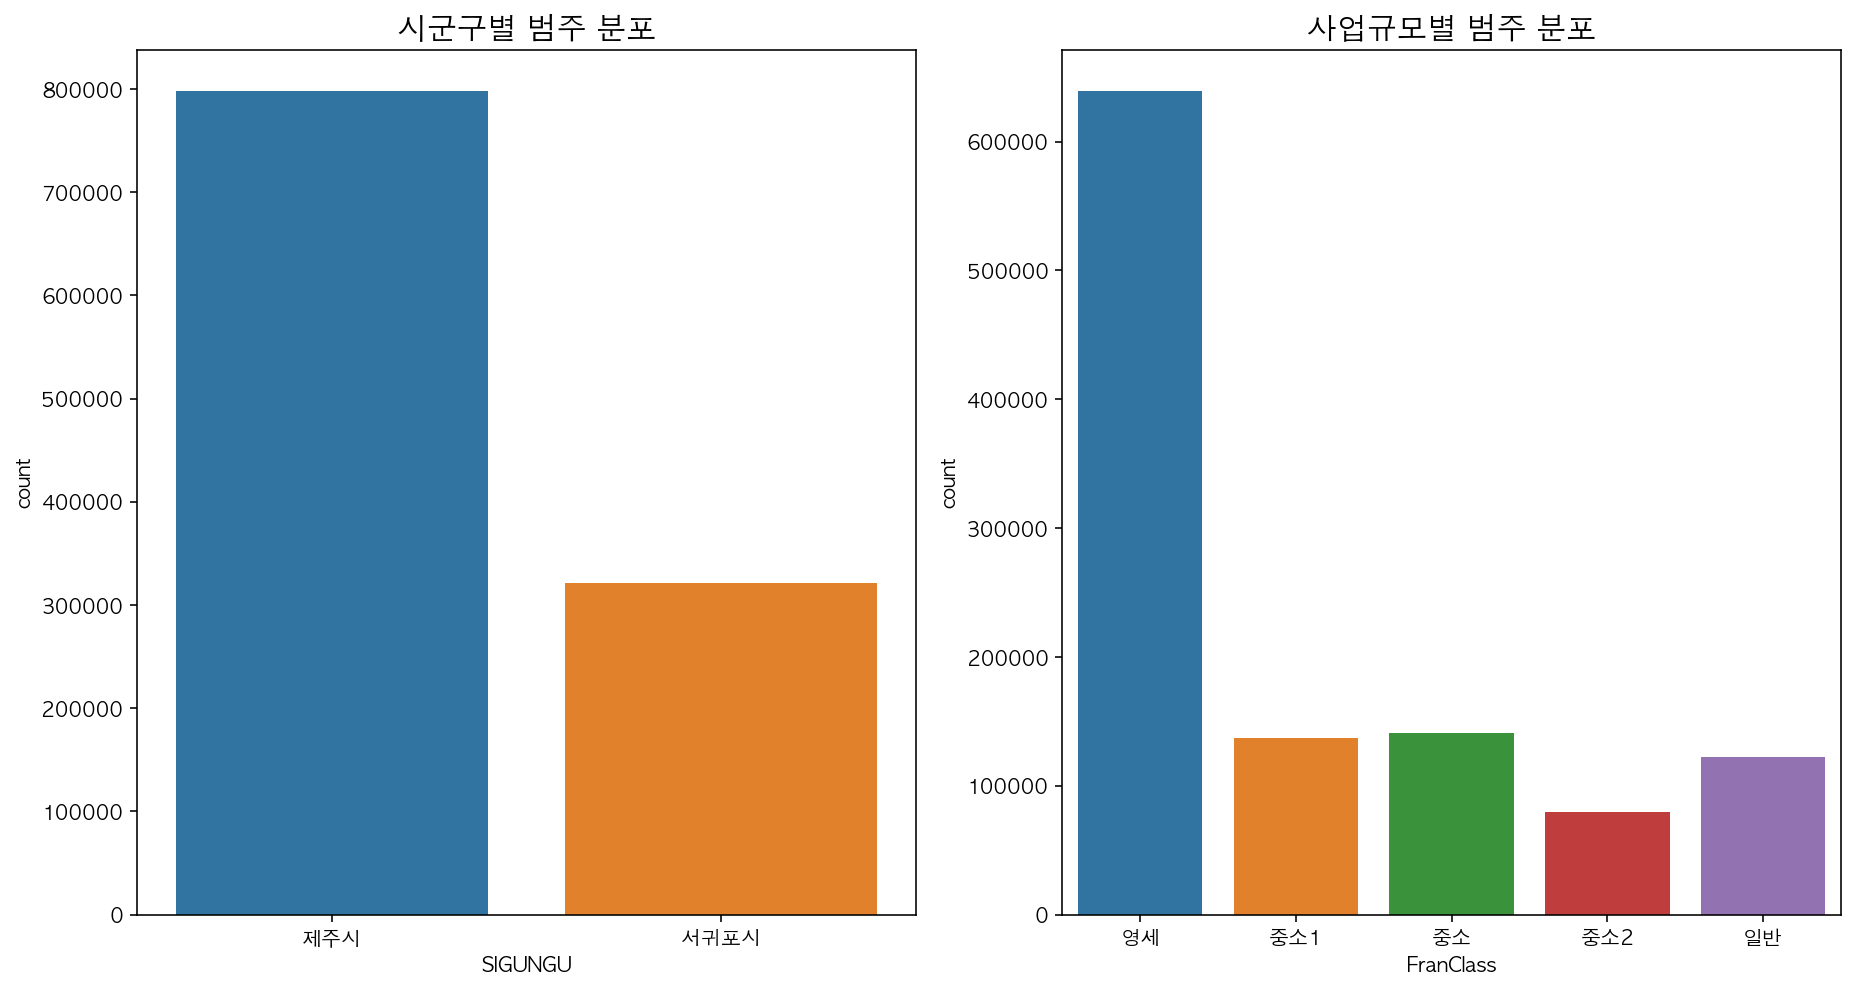

In [135]:
fig, axes = plt.subplots(1, 2, figsize=(13, 7))

sns.countplot(x='SIGUNGU', data=jeju_data, ax=axes[0])
sns.countplot(x='FranClass', data=jeju_data, ax=axes[1])

axes[0].set_title('시군구별 범주 분포', fontdict={'fontsize':15})
axes[1].set_title('사업규모별 범주 분포', fontdict={'fontsize':15})

plt.tight_layout()
plt.show()

Text(0.5, 1.0, '업종별 재난지원금 사용')

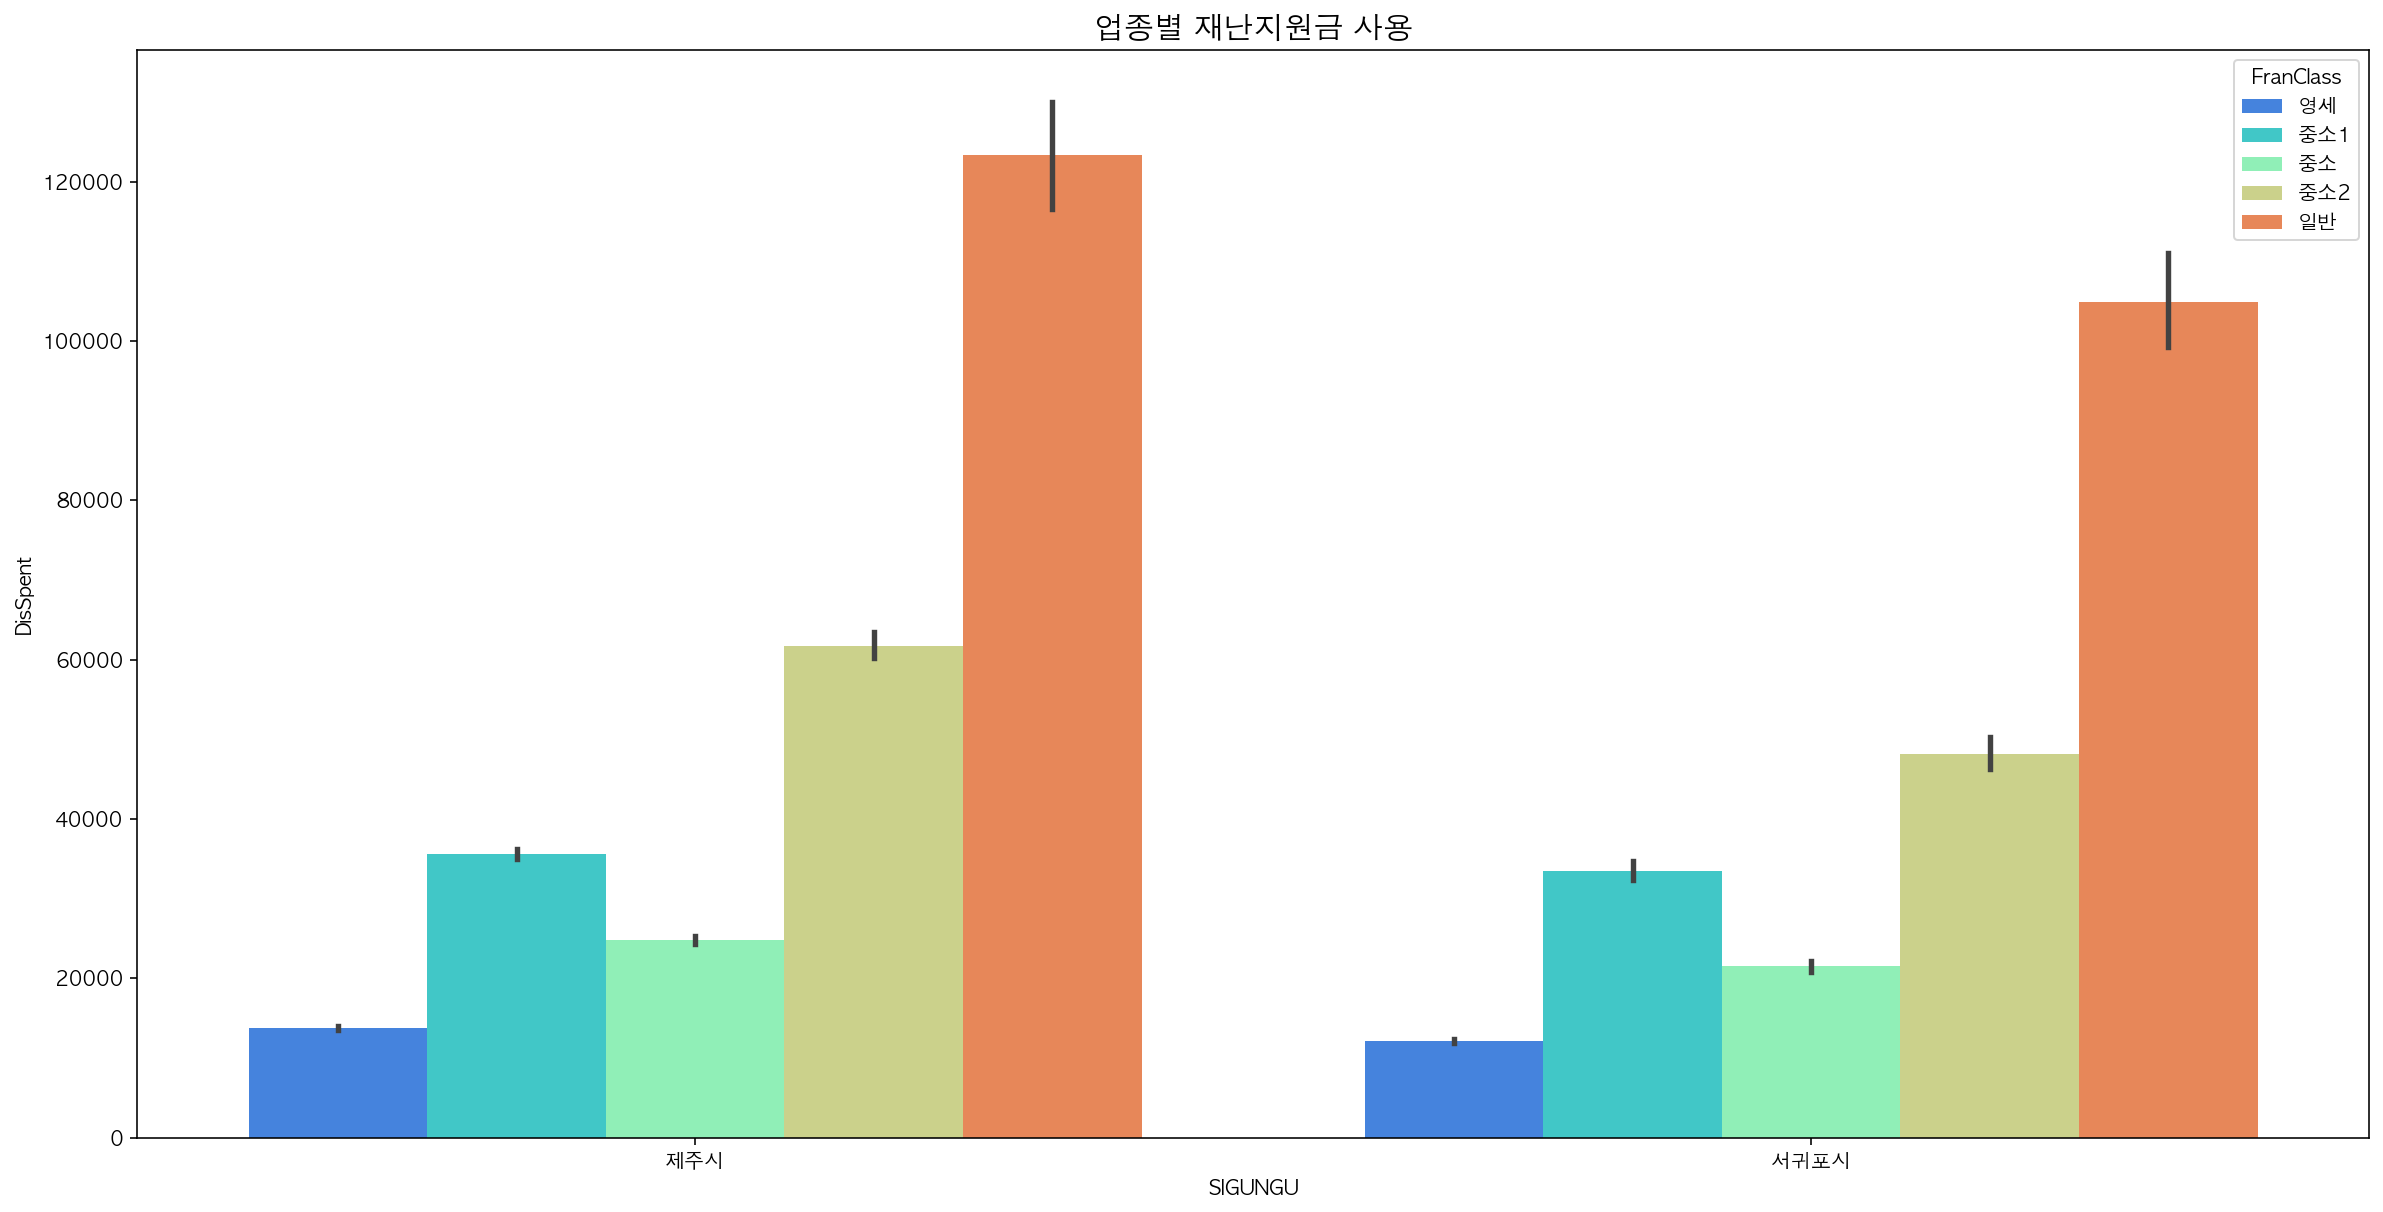

In [138]:
# 업종별 재난지원금 사용

plt.figure(figsize=(20,10))
sns.barplot(y="DisSpent", x='SIGUNGU', palette='rainbow', data=jeju_data,hue = 'FranClass').set_title('업종별 재난지원금 사용', fontdict={'fontsize':15})

<AxesSubplot:xlabel='Type', ylabel='DisSpent'>

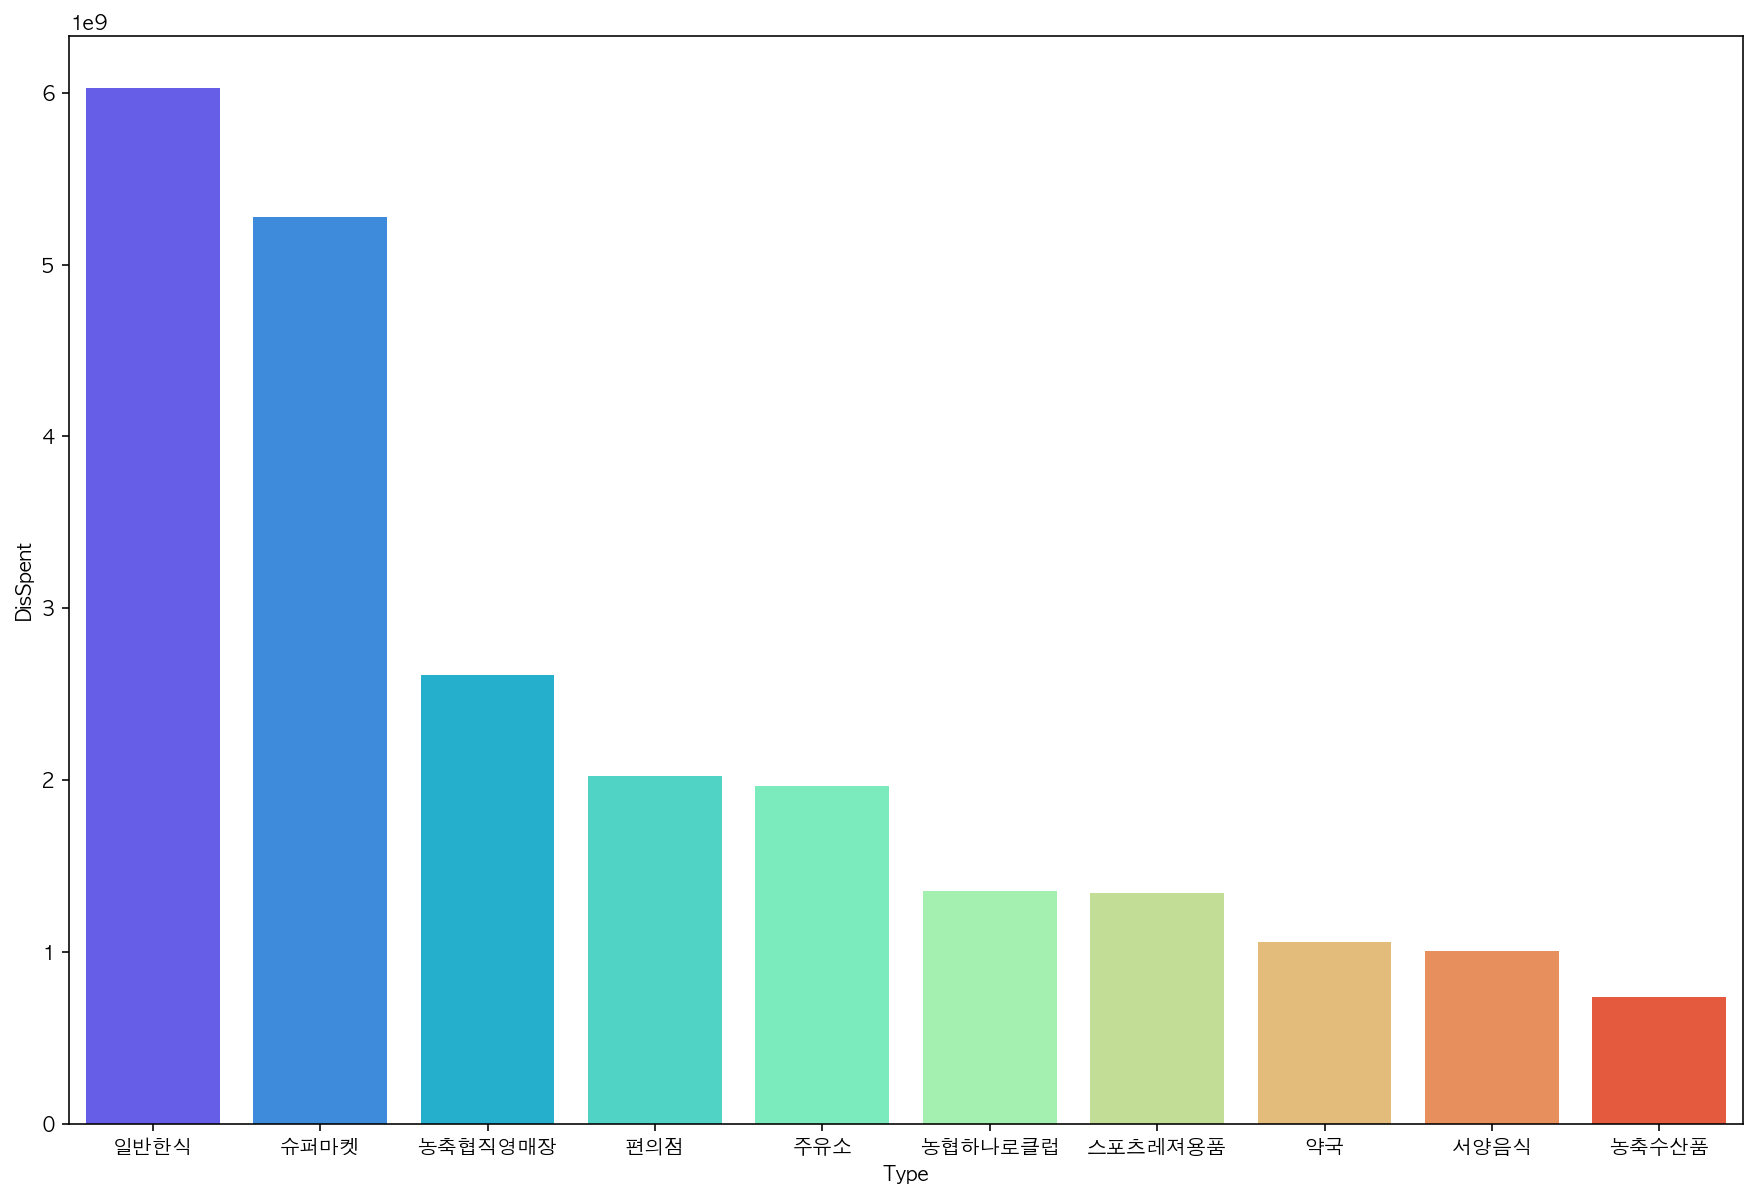

In [146]:
plt.figure(figsize=(15,10))
sns.barplot(y="DisSpent", x='Type', palette='rainbow'
            ,data=jeju_data.groupby('Type').sum().DisSpent.to_frame().reset_index().sort_values(by='DisSpent',ascending=False)[:10])

### 2-3 읍면동별 재난지원금 사용 금액의 차이

In [ ]:
# 읍면동 별 소비 비교
plt.figure(figsize=(15,10))
sns.barplot(y="DisSpent", x='DONG', palette='rainbow'
            ,data = jeju_data.groupby('DONG').sum().DisSpent.to_frame().reset_index().sort_values(by='DisSpent',ascending=False)[:10])

In [140]:
import json
import folium
# 제주공항 좌표(33.510481369447554, 126.49145025928517
f = folium.Figure(width=500, height=400)

m = folium.Map(location = [33.510481369447554, 126.49145025928517],
               tiles = 'http://api.vworld.kr/req/wmts/1.0.0/5AA2EC51-9D9A-35A1-ABD2-ED58B40D7745/Base/{z}/{y}/{x}.png',
               attr = '제주도',
               zoom_start= 9)

m.add_to(f)

In [55]:
jeju_data.head(3)
jeju_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119429 entries, 0 to 1119428
Data columns (total 12 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   YM             1119429 non-null  int64  
 1   SIDO           1119429 non-null  object 
 2   SIGUNGU        1119429 non-null  object 
 3   FranClass      1119429 non-null  object 
 4   Type           1119429 non-null  object 
 5   Time           1119429 non-null  object 
 6   TotalSpent     1119429 non-null  int64  
 7   DisSpent       1119429 non-null  int64  
 8   NumofSpent     1119429 non-null  int64  
 9   NumofDisSpent  1119429 non-null  int64  
 10  POINT_X        1119429 non-null  float64
 11  POINT_Y        1119429 non-null  float64
dtypes: float64(2), int64(5), object(5)
memory usage: 102.5+ MB


In [141]:
import json
import folium
# 제주공항 좌표(33.510481369447554, 126.49145025928517)

m = folium.Map(
    location=[33.510481369447554, 126.49145025928517],
    zoom_start=10
)

for i in data.index:
    folium.Circle(
        #location=[33.510481369447554, 126.49145025928517],
        location = list(data.loc[i, ['POINT_X', 'POINT_Y']]),
        radius = 200,
        color='red'
    ).add_to(m)

m

KeyboardInterrupt: 

In [143]:
m = folium.Map([37.5502, 126.982])

folium.Choropleth(
    geo_data = geo_json,
    name='읍면동 별 총 소비액수',
    data=jeju_data,
    columns=['SIGUNGU', 'TotalSpent'],
    key_on='feature.properties.name',
    fill_color='RdPu',
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name='읍면동 별 총 소비액수'
).add_to(m)

folium.Choropleth(
    geo_data = geo_json,
    name='읍면동 별 재난지원금 소비액수',
    data=jeju_data,
    columns=['SIGUNGU', 'DisSpent'],
    key_on='feature.properties.name',
    fill_color='PuBu',
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name='읍면동 별 재난지원금 소비액수'
).add_to(m)

folium.Choropleth(
    geo_data = geo_json,
    name='읍면동 별 업종 분포',
    data=jeju_data,
    columns=['SIGUNGU', 'DisSpent'],
    key_on='feature.properties.name',
    fill_color='PuBu',
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name='읍면동 별 업종 분포'
).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

m

TypeError: __init__() missing 1 required positional argument: 'geo_data'

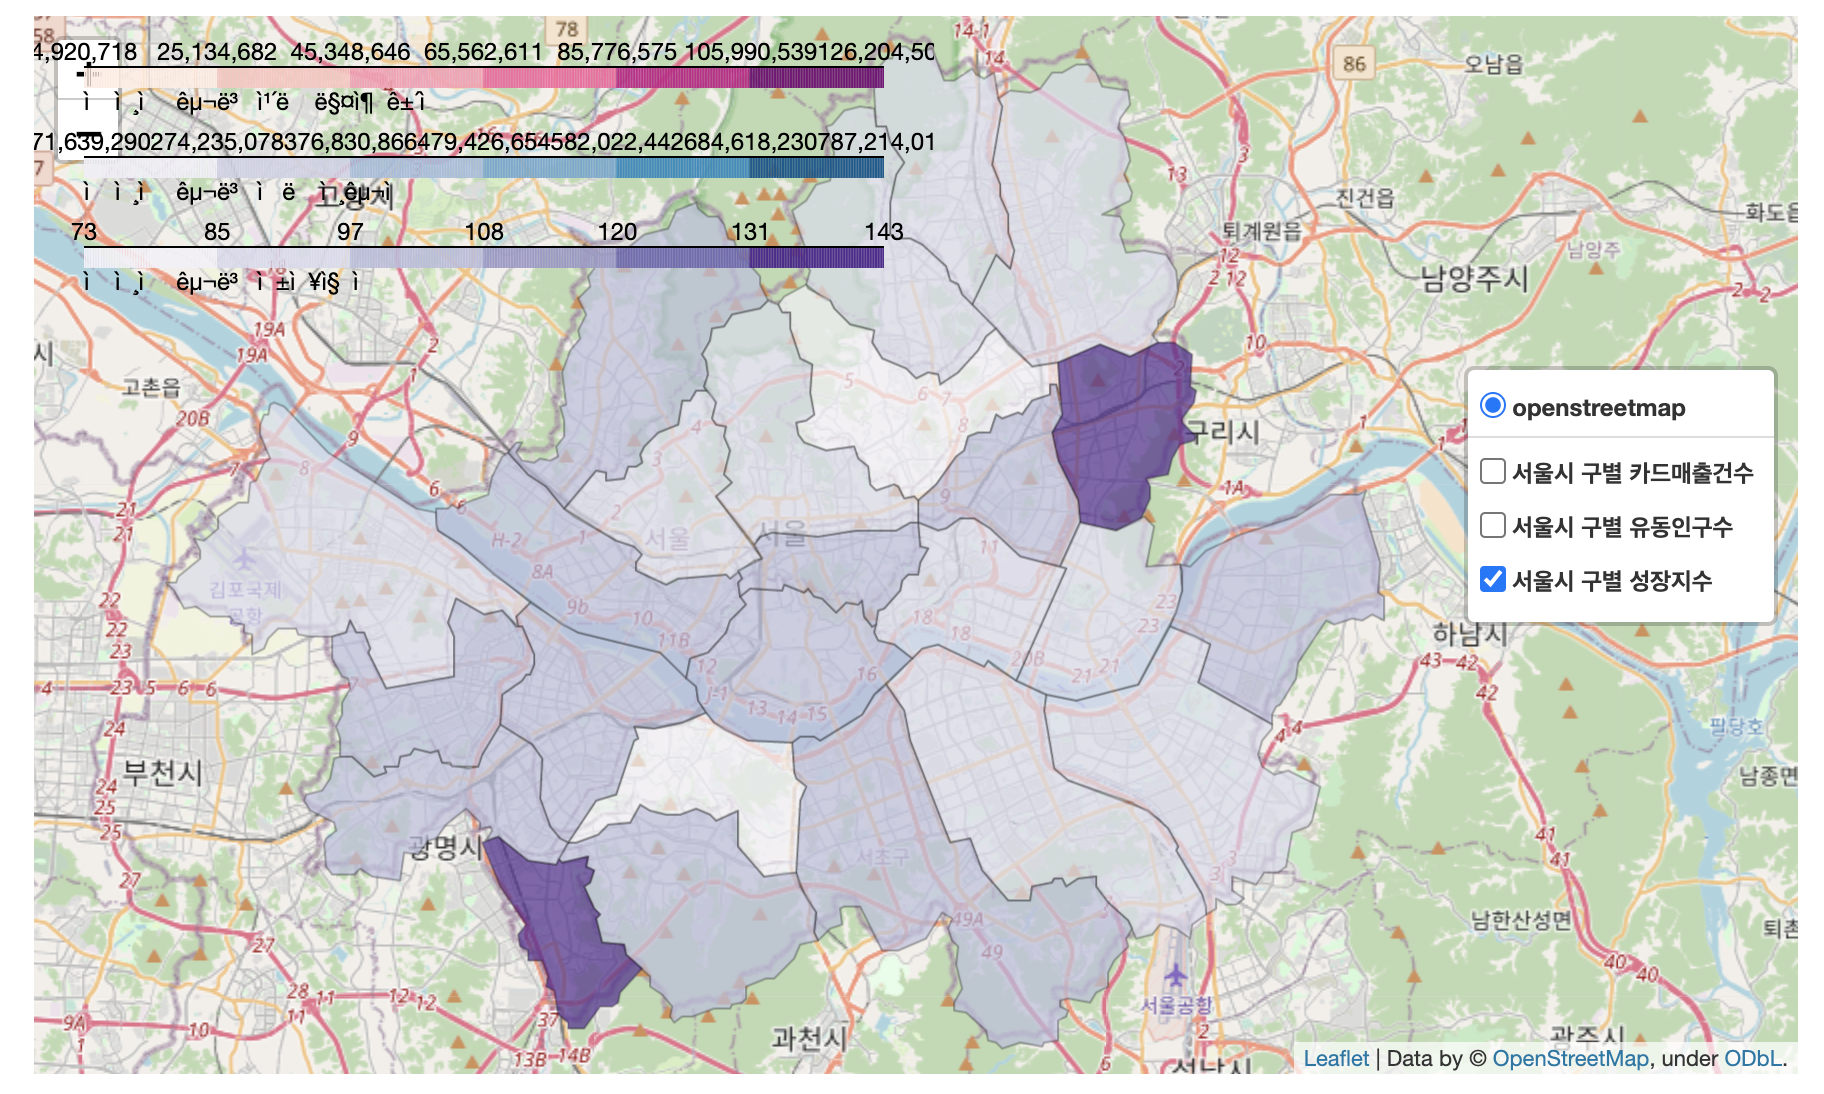

In [149]:
from IPython.display import Image

Image(os.path.join('/Users/sehwaryu/Desktop/folium_ex.png'))

## 3. 제주도와 타 국내 지역과의 재난지원금 사용 금액 비교

데이터: https://www.mois.go.kr/frt/bbs/type010/commonSelectBoardArticle.do?bbsId=BBSMSTR_000000000008&nttId=77379

### 3-1 국내 재난지원금 지급, 신청 현황

### 3-2 재난지원금 지급 형태 분석

- 제주도는 다른 국내 지역과 다른 재난지원금 사용 트렌드를 보일까?